PCC coefficients:
 [0.914593,-0.366568,0.663794,-0.0889736,-0.0988206,-0.0185934,-0.250173,-0.620996]
PRCC coefficients:
 [0.976159,-0.60197,0.876806,-0.152904,-0.110505,0.0731194,-0.491786,-0.838883]
SRC coefficients:
 [0.836047,-0.145642,0.326355,-0.0329979,-0.0368286,-0.00682965,-0.0953962,-0.291483]
Normalized Squared SRC coefficients:
 [0.757082,0.0229751,0.115362,0.00117938,0.0014691,5.05217e-05,0.00985697,0.0920252]
SRRC coefficients:
 [0.880054,-0.147104,0.353713,-0.0301844,-0.0217165,0.0141949,-0.109844,-0.299285]
Pearson correlation coefficients:
 [0.797424,-0.0545644,0.305359,-0.00897983,0.0188226,-0.0610077,-0.0628617,-0.297875]
Spearman correlation coefficients:
 [0.840407,-0.0352644,0.33487,0.012766,0.0204916,-0.0622688,-0.0615572,-0.316529]


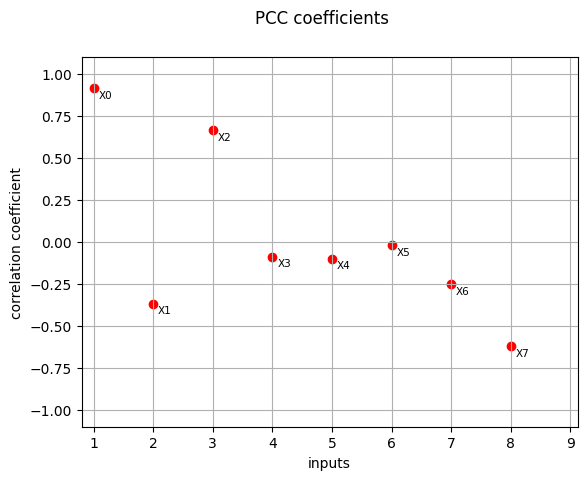

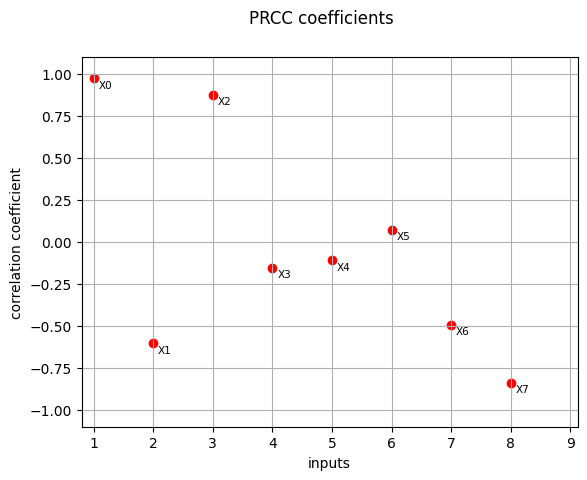

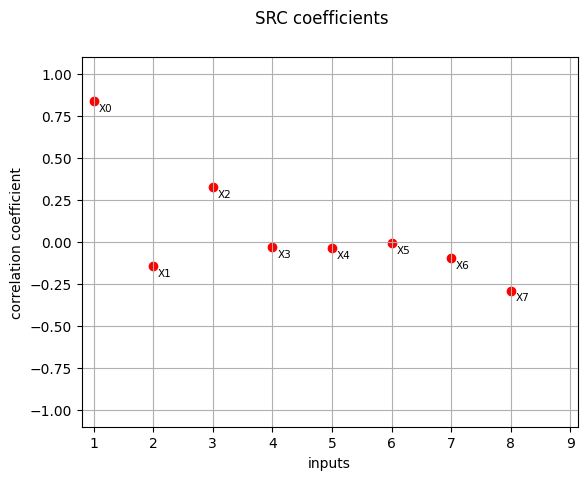

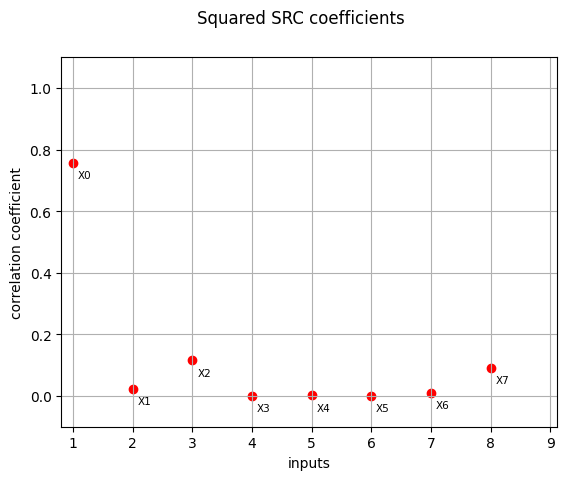

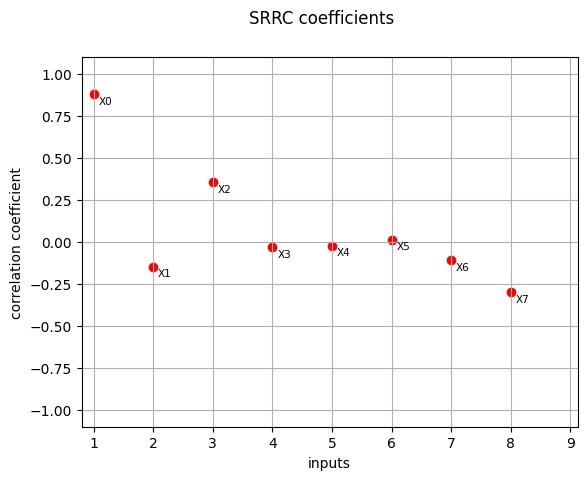

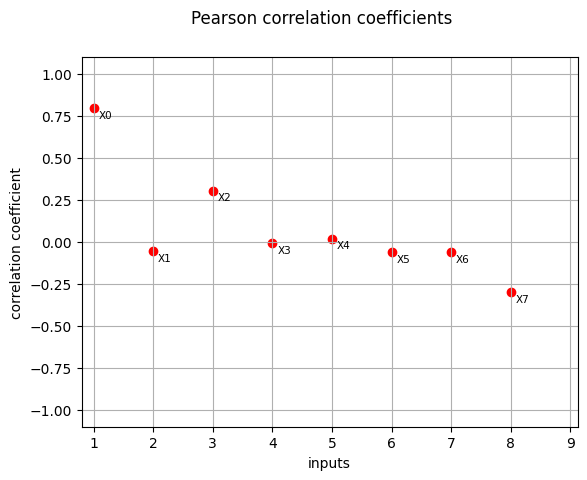

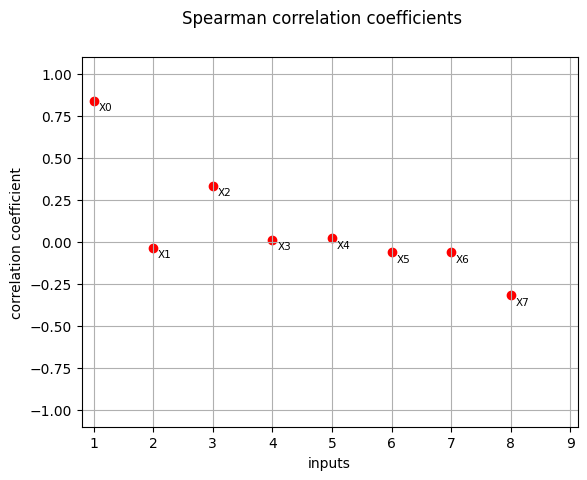

In [5]:
"""
Estimate correlation coefficients
=================================
"""

# %%
# In this example we are going to estimate the correlation between an output sample Y and the corresponding inputs using various estimators:
#
# - PCC: Partial Correlation Coefficients
# - PRCC: Partial Rank Correlation Coefficient
# - SRC: Standard Regression Coefficients
# - SRRC: Standard Rank Regression Coefficient
# - Pearson coefficients
# - Spearman coefficients

import openturns as ot
import openturns.viewer as viewer
import importlib.util
import sys
import os
from matplotlib import pylab as plt
import pandas as pd

ot.Log.Show(ot.Log.NONE)

# Function to load a module from a file
def load_function_and_problem(module_name, file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist.")
    
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    if spec is None:
        raise ImportError(f"Could not load the module from {file_path}.")
    
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module.model, module.problem

# Function to create OpenTURNS distributions from the problem definition
def create_distributions(problem):
    distributions = ot.DistributionCollection()
    for dist_info in problem['distributions']:
        dist_type = dist_info['type']
        params = dist_info['params']
        if dist_type == 'Uniform':
            distributions.add(ot.Uniform(*params))
        elif dist_type == 'Normal':
            distributions.add(ot.Normal(*params))
        elif dist_type == 'LogNormalMuSigma':
            distributions.add(ot.ParametrizedDistribution(ot.LogNormalMuSigma(*params)))
        elif dist_type == 'LogNormal':
            distributions.add(ot.LogNormal(*params))
        elif dist_type == 'Beta':
            distributions.add(ot.Beta(*params))
        elif dist_type == 'Gumbel':
            distributions.add(ot.Gumbel(*params))
        elif dist_type == 'Triangular':
            distributions.add(ot.Triangular(*params))
        else:
            raise ValueError(f"Unsupported distribution type: {dist_type}")
    return ot.ComposedDistribution(distributions)

def save_correlation_to_csv(corr_data, input_names, method, file_path):
    """
    Save correlation coefficients to a CSV file.
    
    Parameters:
    corr_data : Point
        The correlation coefficients.
    input_names : list of str
        The names of the input variables.
    method : str
        The method used to compute the correlation coefficients.
    file_path : str
        The file path to save the CSV file.
    
    CSV File Columns:
    - Variable: The name of the input variable.
    - Correlation_Coefficient: The correlation coefficient value.
    
    Methods:
    - PCC: Partial Correlation Coefficients
    - PRCC: Partial Rank Correlation Coefficient
    - SRC: Standard Regression Coefficients
    - SRRC: Standard Rank Regression Coefficient
    - Pearson: Pearson correlation coefficients
    - Spearman: Spearman correlation coefficients
    """
    data = {
        'Variable': input_names,
        'Correlation_Coefficient': list(corr_data)
    }
    df = pd.DataFrame(data)
    df.to_csv(file_path, index=False)

# Main function to perform the correlation analysis
def main(module_name, file_path, output_dir):
    function_of_interest, problem = load_function_and_problem(module_name, file_path)

    # Define the OpenTURNS model
    ot_model = ot.PythonFunction(problem['num_vars'], 1, function_of_interest)
    
    # Create the input distribution
    distribution = create_distributions(problem)
    input_names = distribution.getDescription()

    size = 100
    inputDesign = ot.SobolIndicesExperiment(distribution, size, True).generate()
    outputDesign = ot_model(inputDesign)

    # Create a CorrelationAnalysis object
    corr_analysis = ot.CorrelationAnalysis(inputDesign, outputDesign)

    # Compute and save PCC coefficients
    pcc_indices = corr_analysis.computePCC()
    print("PCC coefficients:\n", pcc_indices)
    save_correlation_to_csv(pcc_indices, input_names, "PCC", os.path.join(output_dir, "PCC_coefficients.csv"))
    graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
        pcc_indices, input_names, "PCC coefficients"
    )
    viewer.View(graph)

    # Compute and save PRCC coefficients
    prcc_indices = corr_analysis.computePRCC()
    print("PRCC coefficients:\n", prcc_indices)
    save_correlation_to_csv(prcc_indices, input_names, "PRCC", os.path.join(output_dir, "PRCC_coefficients.csv"))
    graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
        prcc_indices, input_names, "PRCC coefficients"
    )
    viewer.View(graph)

    # Compute and save SRC coefficients
    src_indices = corr_analysis.computeSRC()
    print("SRC coefficients:\n", src_indices)
    save_correlation_to_csv(src_indices, input_names, "SRC", os.path.join(output_dir, "SRC_coefficients.csv"))
    graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
        src_indices, input_names, "SRC coefficients"
    )
    viewer.View(graph)

    # Compute and save normalized squared SRC coefficients
    squared_src_indices = corr_analysis.computeSquaredSRC(True)
    print("Normalized Squared SRC coefficients:\n", squared_src_indices)
    save_correlation_to_csv(squared_src_indices, input_names, "Squared SRC", os.path.join(output_dir, "Squared_SRC_coefficients.csv"))
    graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
        squared_src_indices, input_names, "Squared SRC coefficients"
    )
    viewer.View(graph)

    # Compute and save SRRC coefficients
    srrc_indices = corr_analysis.computeSRRC()
    print("SRRC coefficients:\n", srrc_indices)
    save_correlation_to_csv(srrc_indices, input_names, "SRRC", os.path.join(output_dir, "SRRC_coefficients.csv"))
    graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
        srrc_indices, input_names, "SRRC coefficients"
    )
    viewer.View(graph)

    # Compute and save Pearson coefficients
    pearson_correlation = corr_analysis.computePearsonCorrelation()
    print("Pearson correlation coefficients:\n", pearson_correlation)
    save_correlation_to_csv(pearson_correlation, input_names, "Pearson", os.path.join(output_dir, "Pearson_coefficients.csv"))
    graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
        pearson_correlation, input_names, "Pearson correlation coefficients"
    )
    viewer.View(graph)

    # Compute and save Spearman coefficients
    spearman_correlation = corr_analysis.computeSpearmanCorrelation()
    print("Spearman correlation coefficients:\n", spearman_correlation)
    save_correlation_to_csv(spearman_correlation, input_names, "Spearman", os.path.join(output_dir, "Spearman_coefficients.csv"))
    graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
        spearman_correlation, input_names, "Spearman correlation coefficients"
    )
    viewer.View(graph)

    plt.show()

# Run the main function
if __name__ == "__main__":
    module_name = "FloodModel"
    file_path = "examples/FloodModel.py"
    output_dir = "results"
    os.makedirs(output_dir, exist_ok=True)
    main(module_name, file_path, output_dir)
